# AutoEncoder for MNIST

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random 
import os 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

## 參數設定

In [2]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 256  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 載入 MNIST 手寫阿拉伯數字資料

In [3]:
train_ds = torchvision.datasets.MNIST(PATH_DATASETS, train=True, download=True)
test_ds  = torchvision.datasets.MNIST(PATH_DATASETS, train=False, download=True)

## 顯示 MNIST 圖像

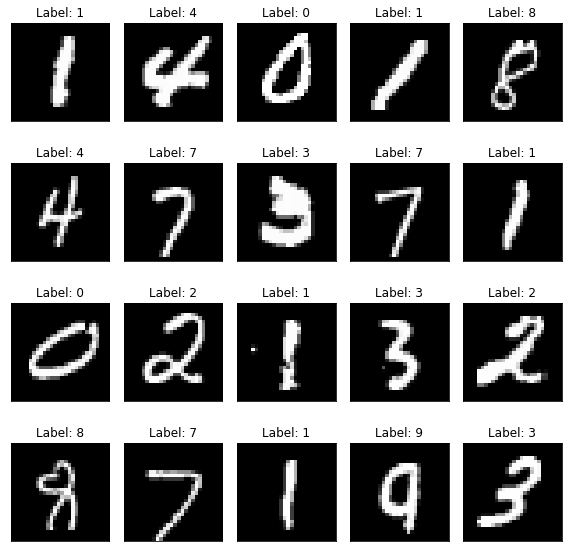

In [4]:
fig, axs = plt.subplots(4, 5, figsize=(8,8))
for ax in axs.flatten():
    # 隨機抽樣
    img, label = random.choice(train_ds)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## 建立 DataLoader

In [5]:
# 轉為張量
train_ds.transform = transforms.ToTensor()
test_ds.transform = transforms.ToTensor()

# 切割20%訓練資料作為驗證資料
m=len(train_ds) # 總筆數
train_data, val_data = random_split(train_ds, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE,shuffle=True)

## 定義模型，含 Encoder and Decoder 

In [6]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        # Convolution
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [7]:
class Decoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            # 反卷積
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## 建立模型

In [8]:
# 固定隨機亂數種子，以利掌握執行結果
torch.manual_seed(0)

# encoder 輸出個數、decoder 輸入個數
d = 4
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128).to(device)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128).to(device)

## 定義損失函數及優化器

In [9]:
loss_fn = torch.nn.MSELoss()
lr= 0.001 # Learning rate

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr)

## 定義加雜訊(Noise)的函數

In [10]:
def add_noise(inputs,noise_factor=0.3):
    noise = inputs+torch.randn_like(inputs)*noise_factor
    noise = torch.clip(noise,0.,1.)
    return noise

## 定義訓練函數

In [11]:
def train_epoch_den(encoder, decoder, device, dataloader, 
                    loss_fn, optimizer,noise_factor=0.3):
    # 指定為訓練階段
    encoder.train()
    decoder.train()
    train_loss = []
    # 訓練
    for image_batch, _ in dataloader:
        # 加雜訊
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        # 編碼
        encoded_data = encoder(image_noisy)
        # 解碼
        decoded_data = decoder(encoded_data)
        # 計算損失
        loss = loss_fn(decoded_data, image_noisy)
        # 反向傳導
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(f'損失：{loss.data}')
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

## 定義測試函數

In [12]:
def test_epoch_den(encoder, decoder, device, dataloader, 
                   loss_fn,noise_factor=0.3):
    # 指定為評估階段
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # 加雜訊
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            # 編碼
            encoded_data = encoder(image_noisy)
            # 解碼
            decoded_data = decoder(encoded_data)
            # 輸出存入 conc_out 變數
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # 合併
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # 驗證資料的損失
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## 定義重建圖像的函數

In [13]:
# fix 中文亂碼 
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False

def plot_ae_outputs_den(epoch,encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        img = test_ds[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        if epoch == 0:
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('原圖')
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('加雜訊')

        if epoch == 0: 
            ax = plt.subplot(3, n, i + 1 + n + n)
        else: 
            ax = plt.subplot(1, n, i + 1)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if epoch == 0 and i == n//2:
            ax.set_title('重建圖像')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

## 訓練

EPOCH 1/30 	 訓練損失：0.099 	 驗證損失： 0.071


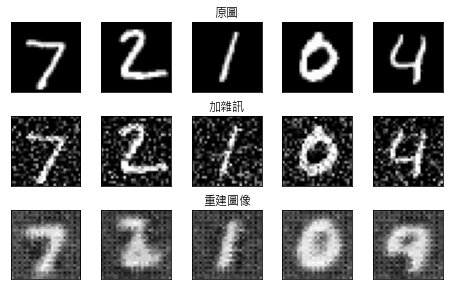

EPOCH 2/30 	 訓練損失：0.062 	 驗證損失： 0.054


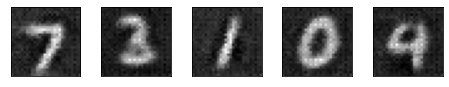

EPOCH 3/30 	 訓練損失：0.056 	 驗證損失： 0.047


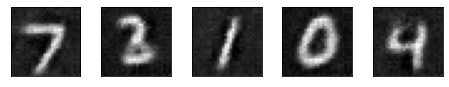

EPOCH 4/30 	 訓練損失：0.054 	 驗證損失： 0.044


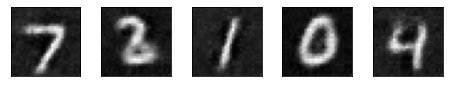

EPOCH 5/30 	 訓練損失：0.053 	 驗證損失： 0.043


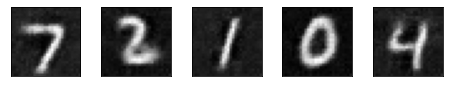

EPOCH 6/30 	 訓練損失：0.052 	 驗證損失： 0.042


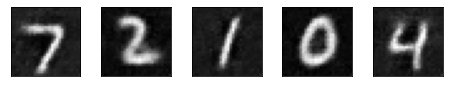

EPOCH 7/30 	 訓練損失：0.052 	 驗證損失： 0.041


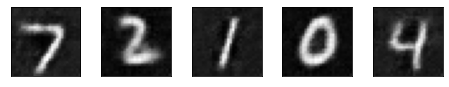

EPOCH 8/30 	 訓練損失：0.052 	 驗證損失： 0.041


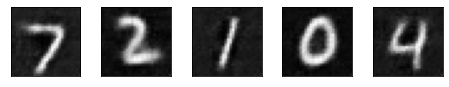

EPOCH 9/30 	 訓練損失：0.051 	 驗證損失： 0.041


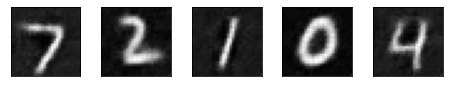

EPOCH 10/30 	 訓練損失：0.051 	 驗證損失： 0.040


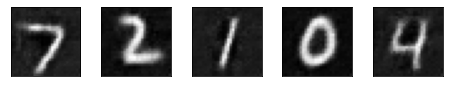

EPOCH 11/30 	 訓練損失：0.051 	 驗證損失： 0.040


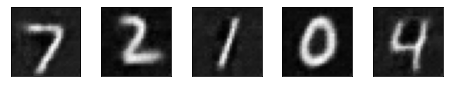

EPOCH 12/30 	 訓練損失：0.051 	 驗證損失： 0.040


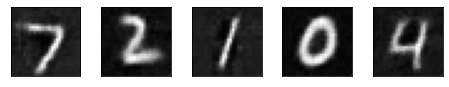

EPOCH 13/30 	 訓練損失：0.051 	 驗證損失： 0.040


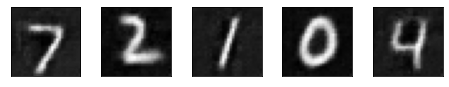

EPOCH 14/30 	 訓練損失：0.051 	 驗證損失： 0.040


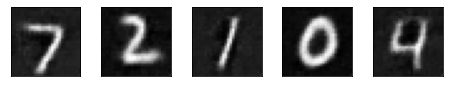

EPOCH 15/30 	 訓練損失：0.050 	 驗證損失： 0.040


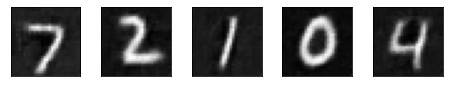

EPOCH 16/30 	 訓練損失：0.050 	 驗證損失： 0.039


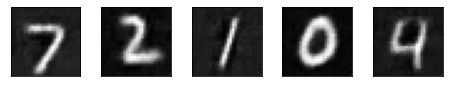

EPOCH 17/30 	 訓練損失：0.050 	 驗證損失： 0.039


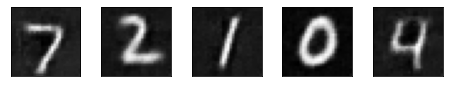

EPOCH 18/30 	 訓練損失：0.050 	 驗證損失： 0.039


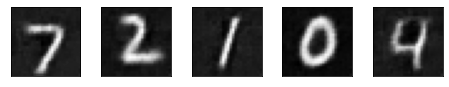

EPOCH 19/30 	 訓練損失：0.050 	 驗證損失： 0.039


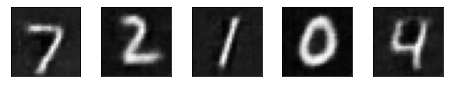

EPOCH 20/30 	 訓練損失：0.050 	 驗證損失： 0.039


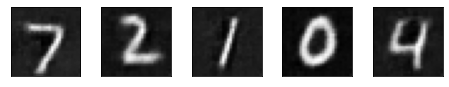

EPOCH 21/30 	 訓練損失：0.050 	 驗證損失： 0.039


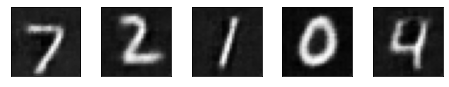

EPOCH 22/30 	 訓練損失：0.050 	 驗證損失： 0.039


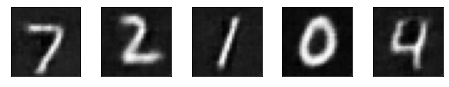

EPOCH 23/30 	 訓練損失：0.050 	 驗證損失： 0.039


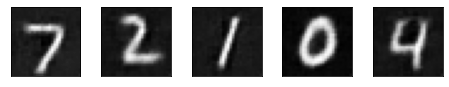

EPOCH 24/30 	 訓練損失：0.050 	 驗證損失： 0.039


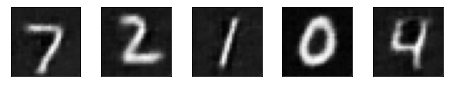

EPOCH 25/30 	 訓練損失：0.050 	 驗證損失： 0.039


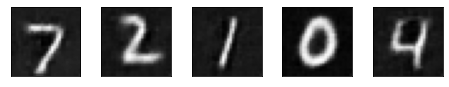

EPOCH 26/30 	 訓練損失：0.050 	 驗證損失： 0.039


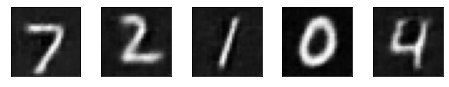

EPOCH 27/30 	 訓練損失：0.050 	 驗證損失： 0.039


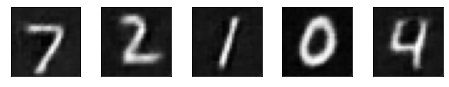

EPOCH 28/30 	 訓練損失：0.050 	 驗證損失： 0.039


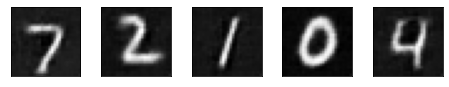

EPOCH 29/30 	 訓練損失：0.050 	 驗證損失： 0.039


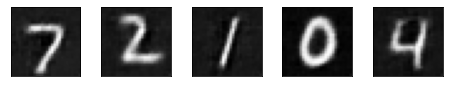

EPOCH 30/30 	 訓練損失：0.050 	 驗證損失： 0.038


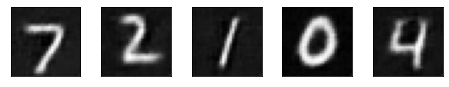

In [14]:
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    # print(f'EPOCH {epoch + 1}/{num_epochs}')
    # 訓練
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    # 驗證
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validation loss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print(f'EPOCH {epoch + 1}/{num_epochs} \t 訓練損失：{train_loss:.3f}' + 
          f' \t 驗證損失： {val_loss:.3f}')
    plot_ae_outputs_den(epoch,encoder,decoder,noise_factor=noise_factor)

In [15]:
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()

0.038353219628334045

## 使用隨機亂數生成圖像

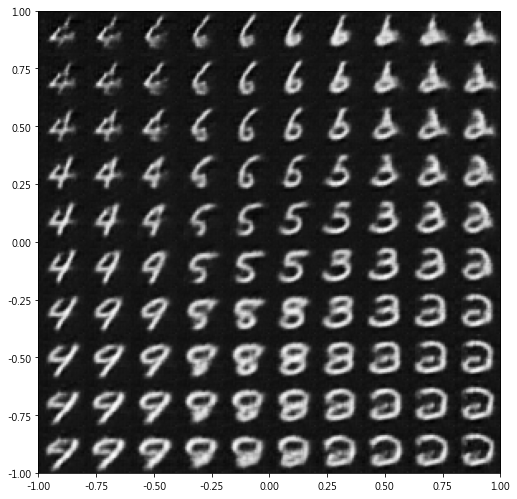

In [16]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    # 隨機亂數
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y], [x, y]]).reshape(-1,4).to(device)
            # print(z.shape)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

## 觀察模型中間的潛在因子(Latent Factor)，即編碼器的輸出

In [17]:
encoded_samples = []
for sample in test_ds:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"變數 {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,變數 0,變數 1,變數 2,變數 3,label
0,-1.471296,0.632351,-1.097417,-2.521446,7
1,1.166635,1.605482,0.351870,-0.689173,2
2,-0.120288,2.027773,-1.053953,-0.020504,1
3,-0.095482,-0.757910,0.463051,0.633070,0
4,-2.163990,-0.329041,-0.273953,-0.039250,4
...,...,...,...,...,...
9995,1.611491,0.678019,0.056426,-1.228752,2
9996,0.495784,0.537345,1.034432,-0.500907,3
9997,-0.833323,0.153424,-1.043410,-0.469312,4
9998,0.332048,-0.389736,-0.612786,0.190224,5


In [20]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(encoded_samples, x='變數 0', y='變數 1', 
                 color=encoded_samples.label.astype(str), opacity=0.7)
fig_widget = go.FigureWidget(fig)
fig_widget

FigureWidget({
    'data': [{'hovertemplate': 'color=7<br>變數 0=%{x}<br>變數 1=%{y}<extra></extra>',
            …

## TSNE 降維

In [21]:
# TSNE 降維
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# 繪圖
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str)
                 ,labels={'0': 'tsne-變數1', '1': 'tsne-變數2'})
fig_widget = go.FigureWidget(fig)
fig_widget

f:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

f:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



FigureWidget({
    'data': [{'hovertemplate': 'color=7<br>tsne-變數1=%{x}<br>tsne-變數2=%{y}<extra></extra>',
    …